In [1]:
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '../src/')
from ploting import *
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

def generate_data(sampleSize=1000):
    x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, sampleSize))).T
    r_data = np.float32(np.random.normal(size=(sampleSize,1)))
    y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)
    
    return train_test_split(x_data, y_data, random_state=42)

In [3]:
X_train, X_test, y_train, y_test = generate_data()

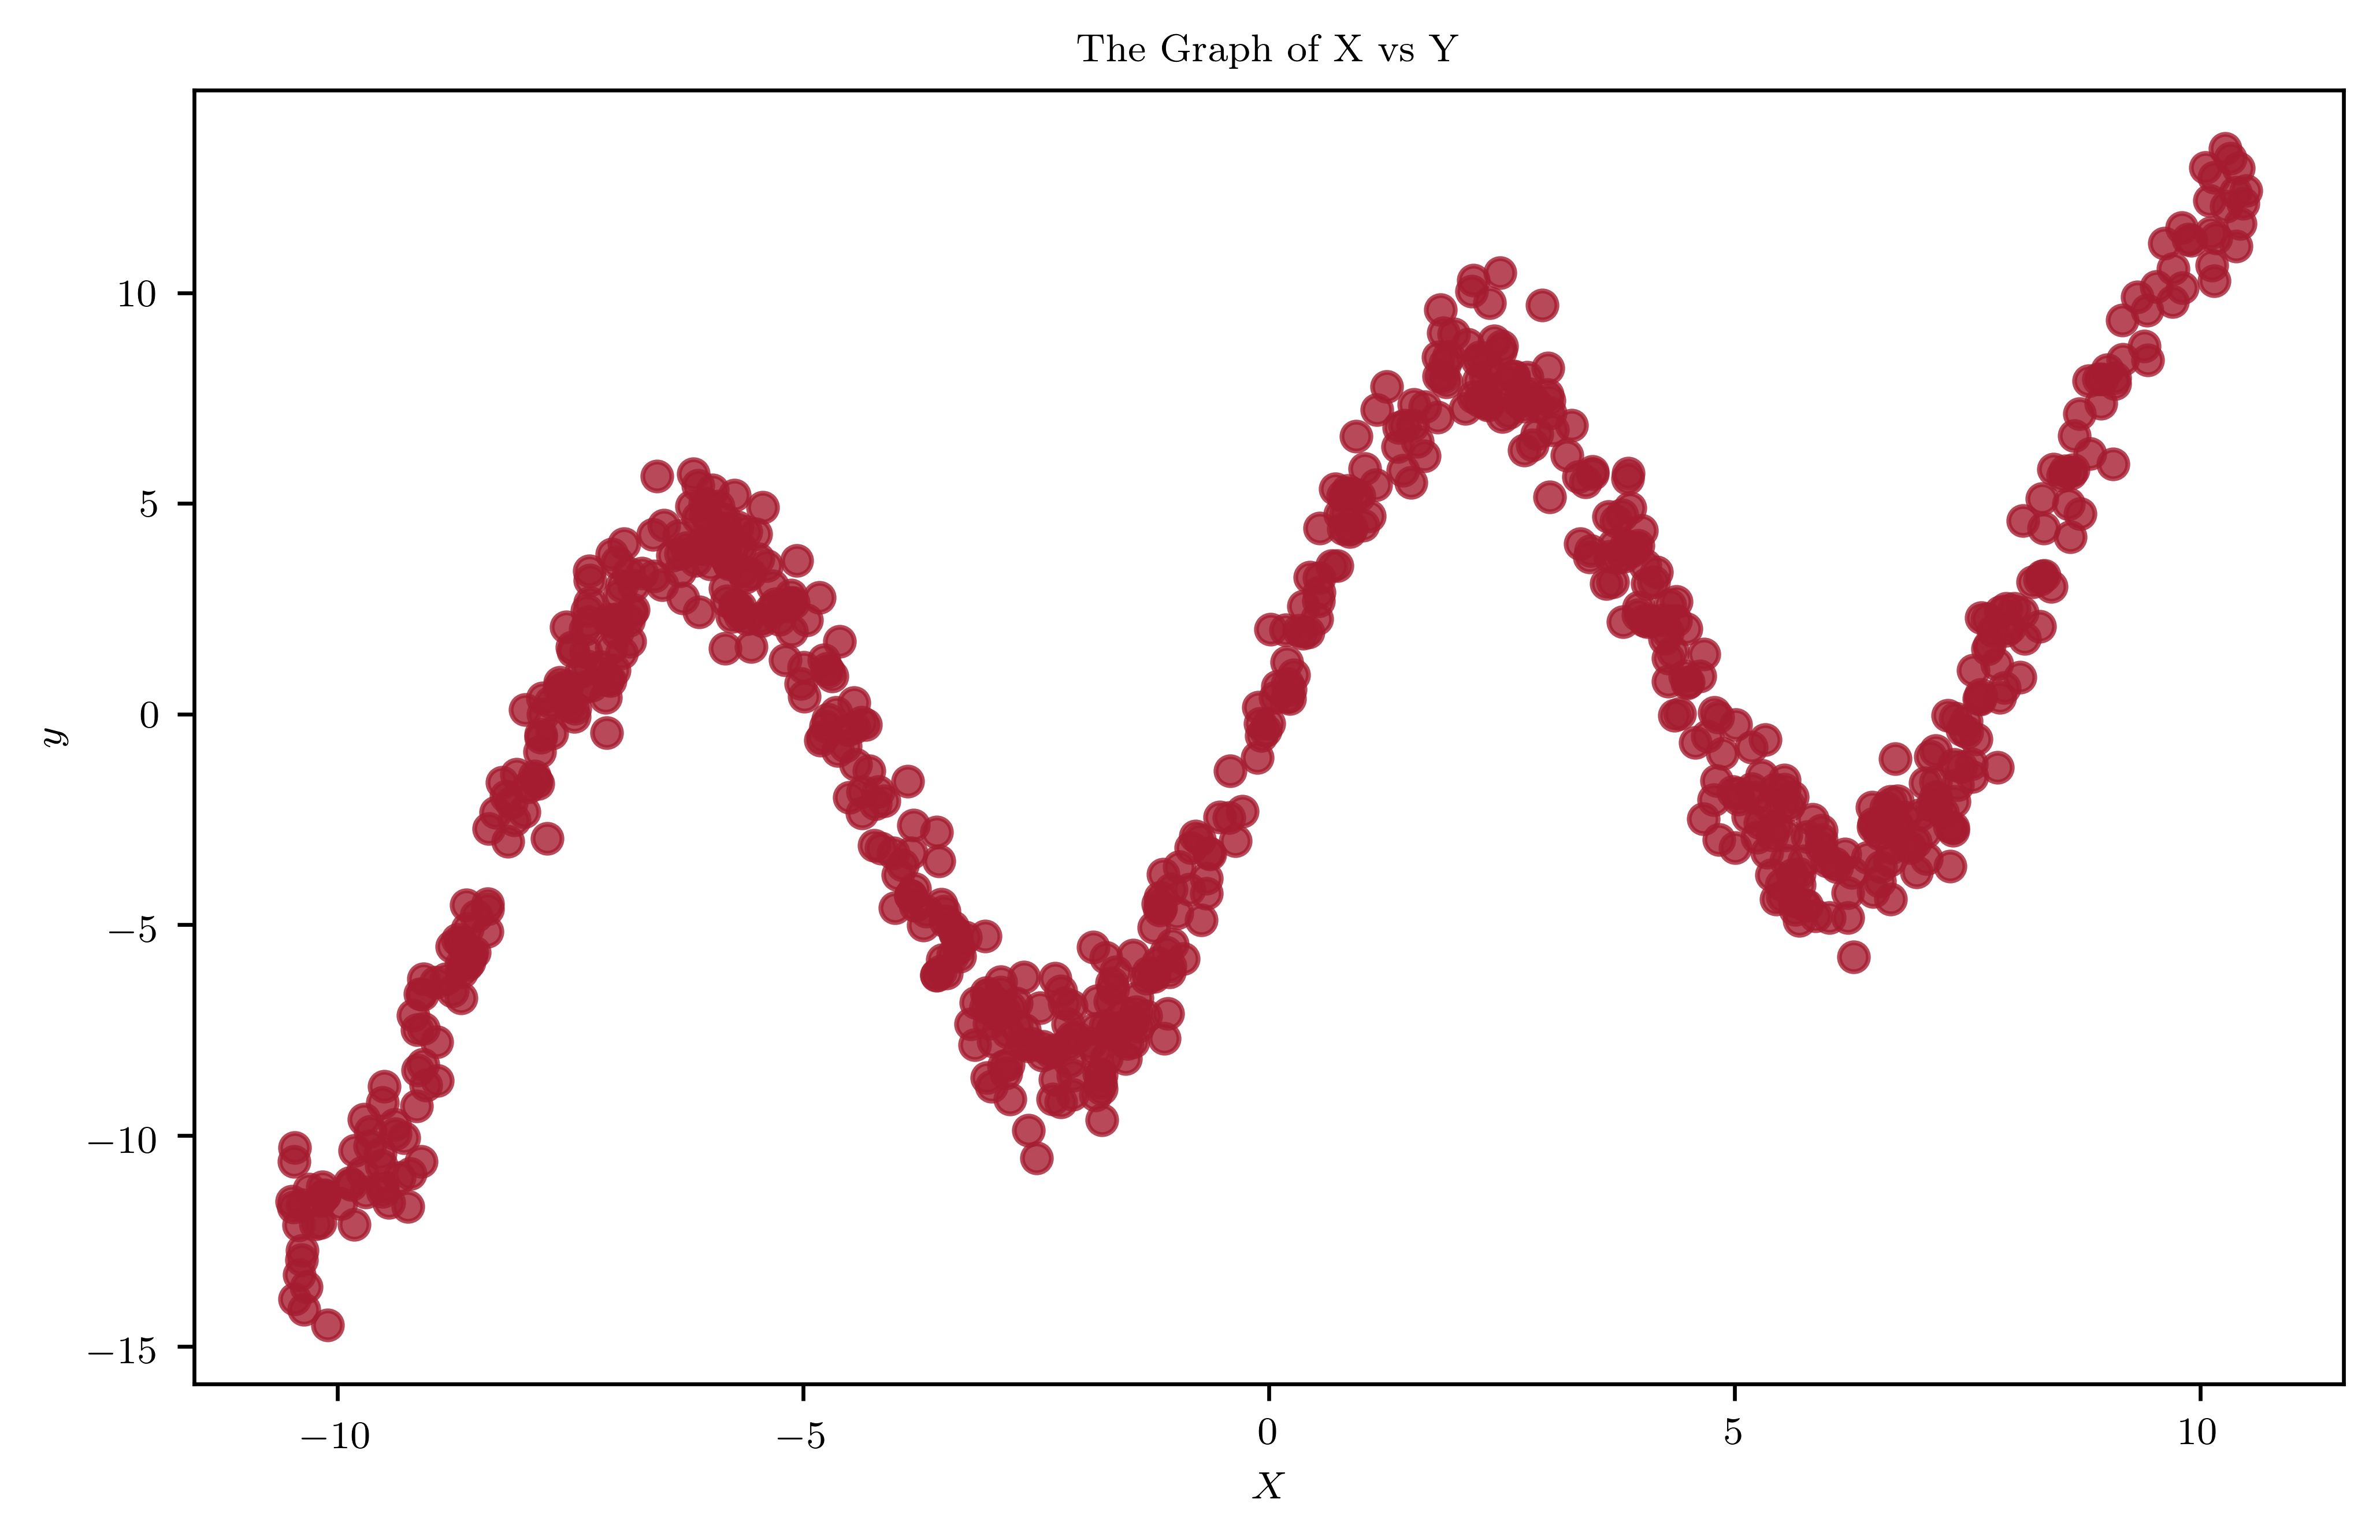

In [4]:
latexify(fig_width=8)
sns.regplot(X_train, y_train, fit_reg=False)
plt.xlabel('$X$')
plt.ylabel('$y$')
plt.title("The Graph of X vs Y");

## Define MDN

We specialize to the case of isotropic covariances (PRML p. 273), so the covariance matrix is diagonal with equal diagonal elements, i.e., the variances for each dimension of y are equivalent. therefore, the MDN outputs pi & sigma scalars for each mixture component, and a mu vector for each mixture component containing means for each target variable. NOTE: we could use the shorthand `d_out = 3*k`, since our target variable for this project only has a dimensionality of 1, but  the following is more general. d_out = (t + 2) * k  # t is L from PRML p. 274 NOTE: actually cleaner to just separate pi, sigma^2, & mu into separate functions.

In [5]:
import torch
import math
from torch.autograd import Variable
import torch.nn as nn

h = 50  # dimensionality of hidden layer
k = 30  # K mixing components (PRML p. 274)

In [6]:
x_train = Variable(torch.from_numpy(X_train))
y_train = Variable(torch.from_numpy(y_train), requires_grad=False)

In [7]:
class MDN(nn.Module):
    
    def __init__(self, hidden_size, num_mixtures):
        super(MDN, self).__init__()
        self.fc_in = nn.Linear(1, hidden_size) 
        self.relu = nn.ReLU()
        self.pi_out = torch.nn.Sequential(nn.Linear(hidden_size, num_mixtures),nn.Softmax())
        self.sigma_out = nn.Linear(hidden_size, num_mixtures)
        self.mu_out = nn.Linear(hidden_size, num_mixtures)  
    
    def forward(self, x):

        out = self.fc_in(x)
        out = self.relu(out)
        out_pi = self.pi_out(out)
        out_sigma = torch.exp(self.sigma_out(out))
        out_mu = self.mu_out(out)
        
        return (out_pi, out_sigma, out_mu)


In [8]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalisation factor for gaussian.
def gaussian_distribution(y, mu, sigma):
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = - 0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI


def mdn_loss_function(out_pi, out_sigma, out_mu, y):
    
    result = gaussian_distribution(y, out_mu, out_sigma) * out_pi
    result = torch.sum(result, dim=1)
    result = - torch.log(result)
    
    return torch.mean(result)

In [9]:
model = MDN(hidden_size=5, num_mixtures=10)

In [10]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Loss = []
epoch = []
for t in range(10000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, y_train)
    Loss.append(loss.data[0])
    epoch.append(t)
    if (t % 500 == 0):
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 4.795803546905518
500 2.9297988414764404
1000 2.5767247676849365
1500 2.400303363800049
2000 2.2476460933685303
2500 2.0653233528137207
3000 1.845818042755127
3500 1.6572773456573486
4000 1.5519578456878662
4500 1.5029377937316895
5000 1.4786900281906128
5500 1.4602237939834595
6000 1.4410768747329712
6500 1.423516035079956
7000 1.4104188680648804
7500 1.4041022062301636
8000 1.392219066619873
8500 1.3890328407287598
9000 1.3819241523742676
9500 1.3810685873031616


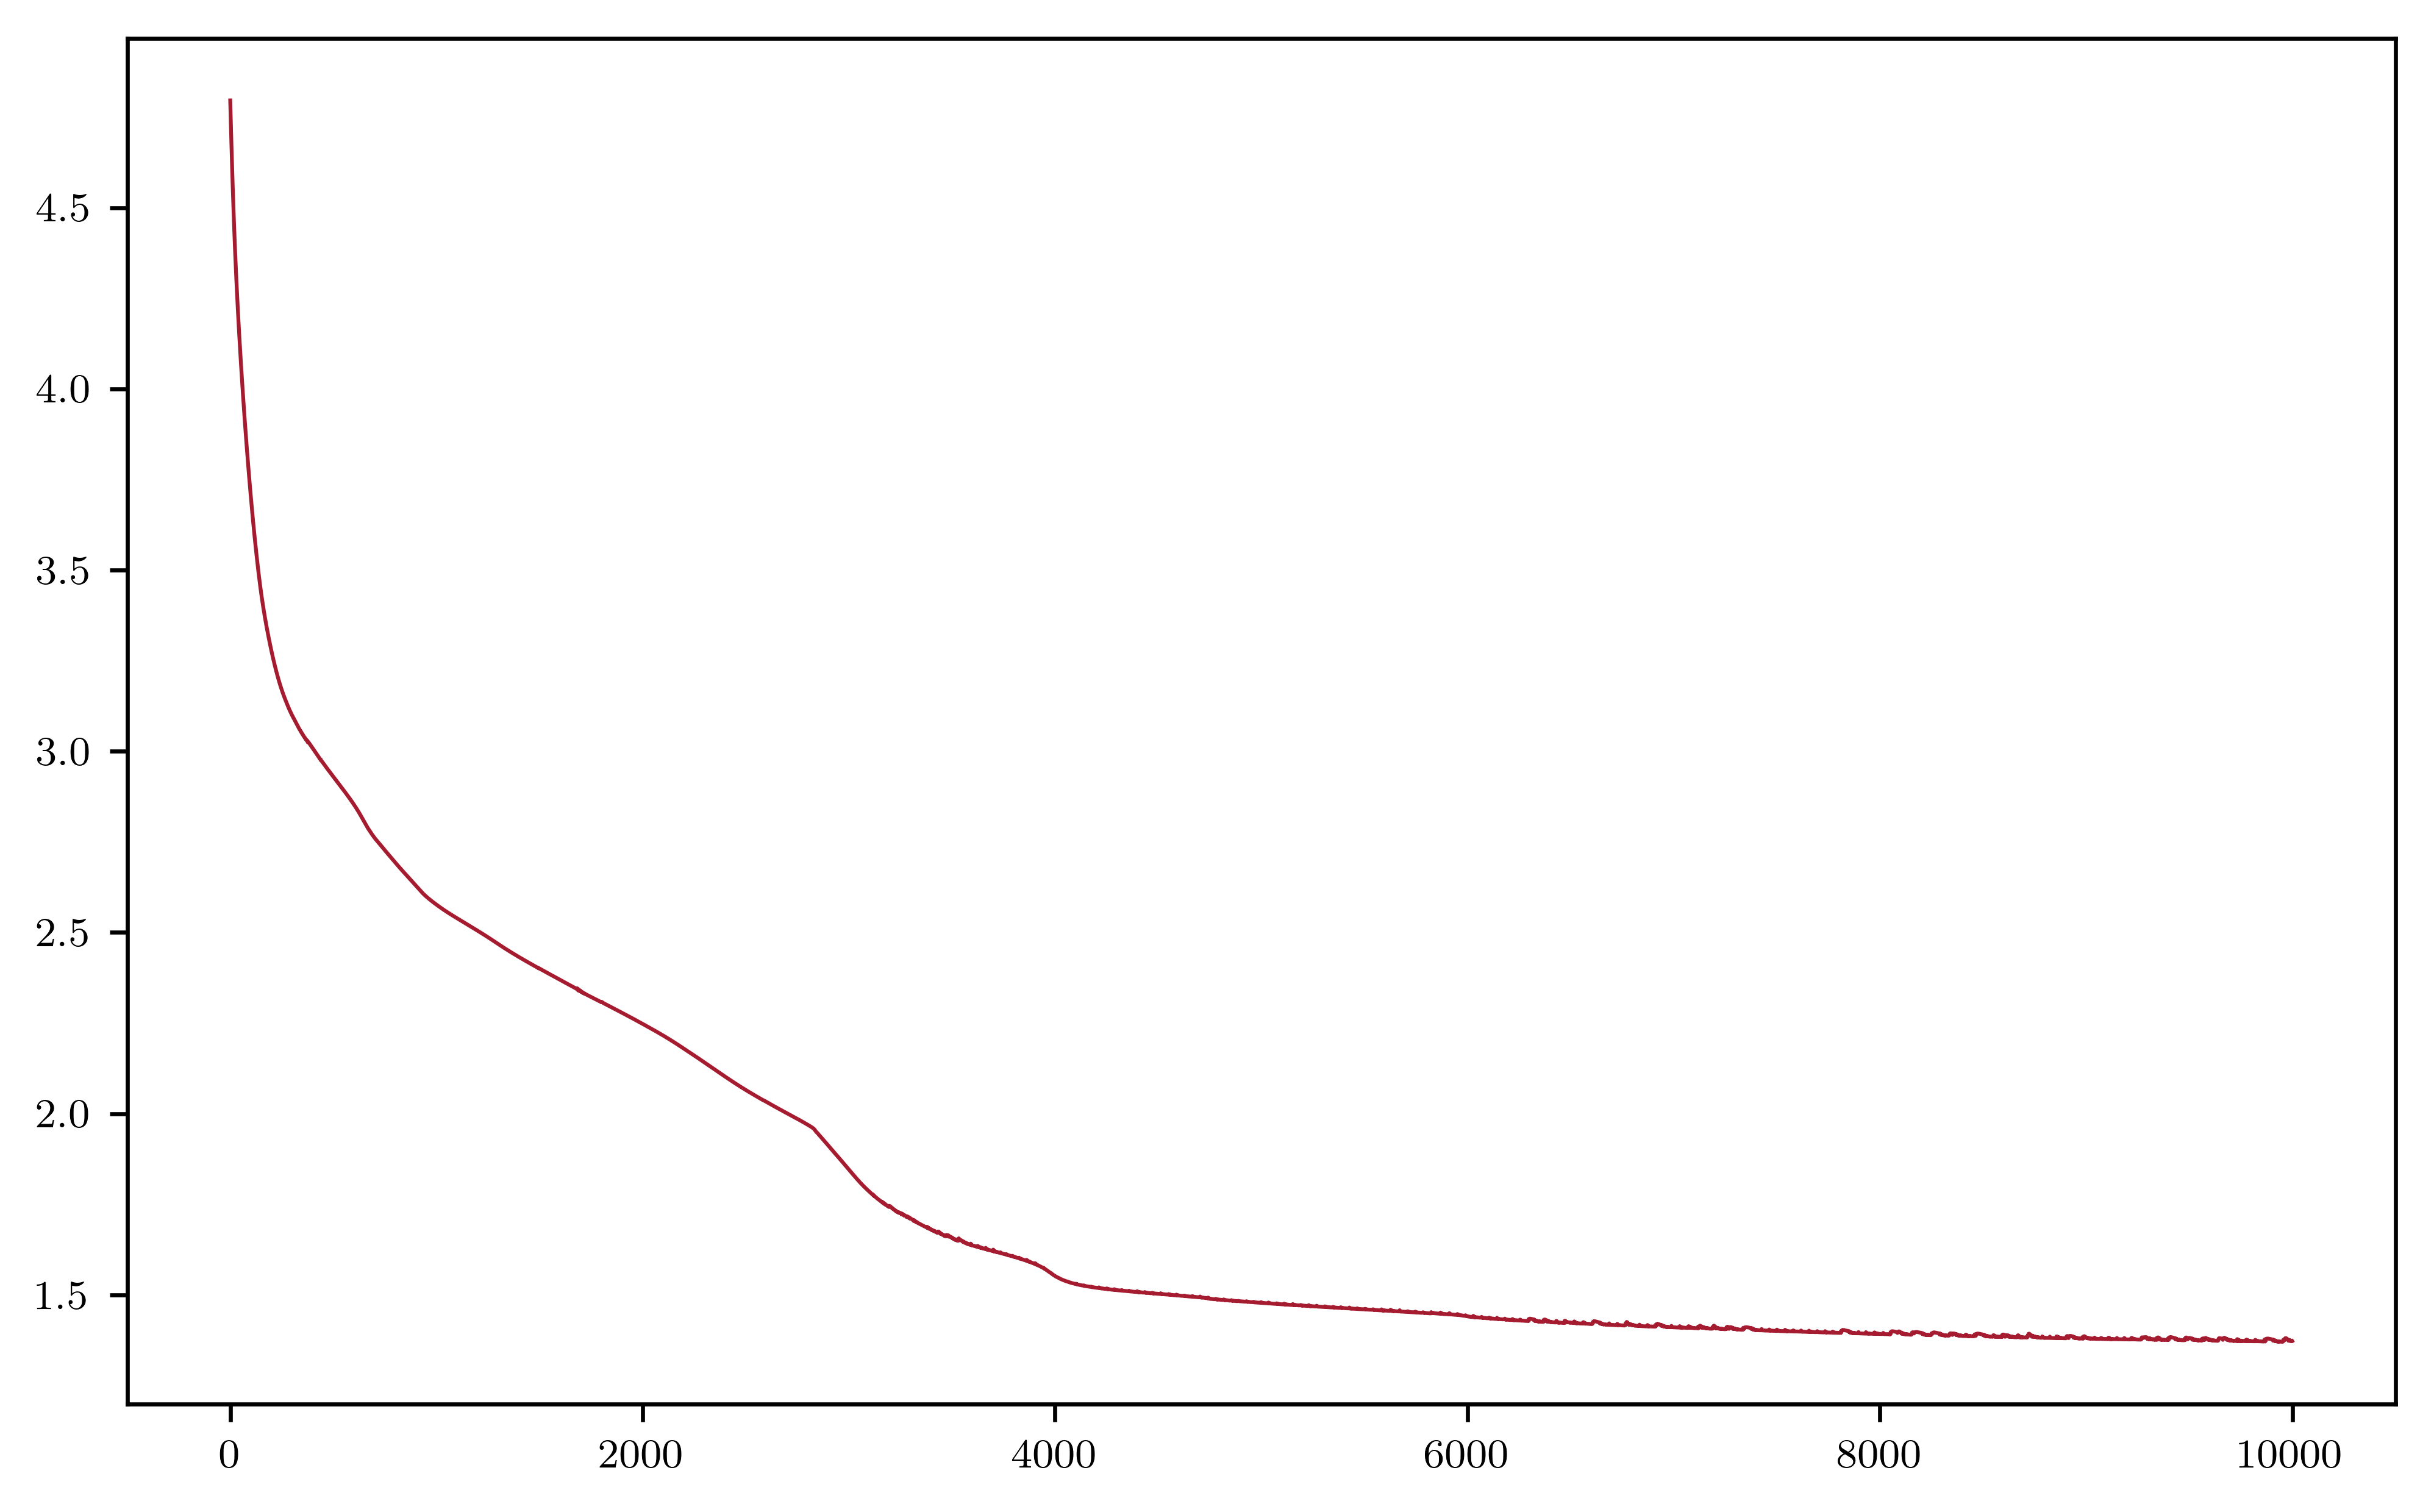

In [11]:
plt.plot(epoch, Loss)

In [12]:
x_test = Variable(torch.from_numpy(X_test))
(out_pi_test, out_sigma_test, out_mu_test) = model(x_test)

In [13]:
out_pi_test_data = out_pi_test.data.numpy()
out_sigma_test_data = out_sigma_test.data.numpy()
out_mu_test_data = out_mu_test.data.numpy()

In [17]:
out_mu_test_data

array([[  3.9600606 ,  -0.6149978 ,   1.91163814, ...,  -1.19188321,
          3.52251005, -22.26524353],
       [  2.49096012,  -6.44241905,   2.97935438, ...,  -0.35328317,
          2.6282146 , -15.84826088],
       [  3.21016026,  -0.30303907,   1.20289481, ...,   2.53952169,
          1.58570409,  -8.66692257],
       ..., 
       [  4.56753683,  11.59654999,  -1.5116117 , ...,   4.65927649,
          1.11399651,  -5.87799644],
       [  3.25994539,   0.13340735,   1.10333371, ...,   2.6172688 ,
          1.56840324,  -8.56463242],
       [  3.19934893,  -3.63611031,   2.47575212, ...,  -0.88948405,
          3.09091806, -19.28002167]], dtype=float32)